In [1]:
# !pip install recbole
# !pip install ray
# !pip install "numpy<2.0"
# !pip install kmeans_pytorch
# !pip install "scipy<1.12"
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install pyarrow
# !pip install tensorflow
# !pip install spark-nlp
# !pip install emoji
# !pip install contractions

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StopWordsRemover, NGram

spark = SparkSession.builder \
    .appName("Amazon_Reviews_EDA_Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

parquet_path = 'reviews_final_parquet'

print(f"Loading cleaned data from {parquet_path}...")
df_spark = spark.read.parquet(parquet_path)

print("Counting records to trigger cache...")
print(f"Total Records: {df_spark.count():,}")
print("Data loaded and cached!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/15 19:22:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loading cleaned data from reviews_final_parquet...


Counting records to trigger cache...


[Stage 1:==================================================>    (368 + 6) / 400]

Total Records: 75,198,298
Data loaded and cached!


In [2]:
df_spark = df_spark.withColumn("wordCount", F.size(F.col("review_tokens_nostop")))

Total Users: 4283442
Total Items: 2260469
Total Reviews: 75198298
Global Matrix Density: 0.000777%


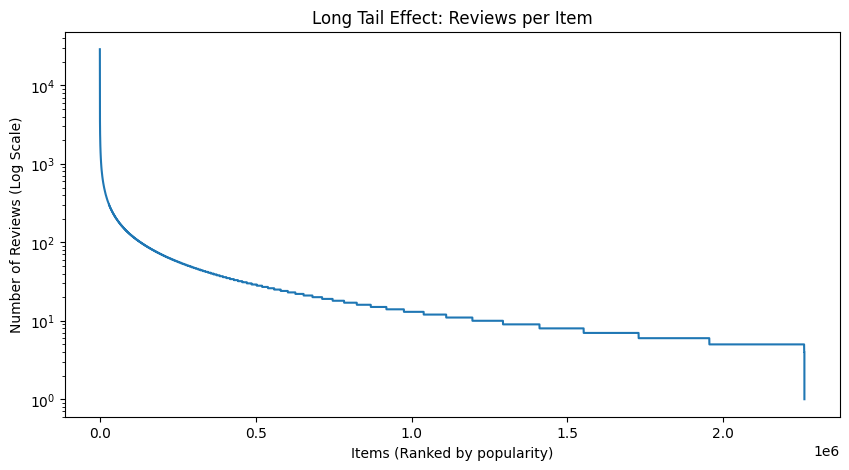

In [ ]:
def perform_sparsity_analysis(df):
    """Calculates matrix density and long-tail statistics."""
    n_users = df.select("reviewerID").distinct().count()
    n_items = df.select("asin").distinct().count()
    n_reviews = df.count()

    density = (n_reviews / (n_users * n_items)) * 100

    print(f"Total Users: {n_users}")
    print(f"Total Items: {n_items}")
    print(f"Total Reviews: {n_reviews}")
    print(f"Global Matrix Density: {density:.6f}%")

    # Interactions per item for Long Tail visualization
    item_counts = df.groupBy("asin").count().orderBy(F.desc("count")).toPandas()

    plt.figure(figsize=(10, 5))
    plt.plot(item_counts['count'].values)
    plt.title('Long Tail Effect: Reviews per Item')
    plt.xlabel('Items (Ranked by popularity)')
    plt.ylabel('Number of Reviews (Log Scale)')
    plt.yscale('log')
    plt.show()

perform_sparsity_analysis(df_spark)


--- Verified Purchase Stats ---
   verified  avgRating     count
0      True   4.379207  60343707
1     False   4.223455  14854591


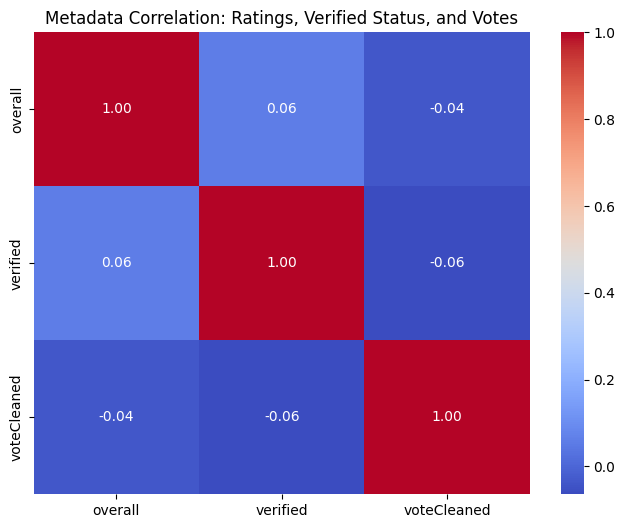

In [ ]:
def analyze_metadata_correlations(df):
    """Analyzes the reliability of reviews based on 'verified' status and votes."""
    # Average rating by Verified status
    verified_stats = df.groupBy("verified").agg(F.avg("overall").alias("avgRating"), F.count("*").alias("count")).toPandas()
    print("\n--- Verified Purchase Stats ---")
    print(verified_stats)

    # Sample for correlation heatmap
    sample_pd = df.select("overall", "verified", "voteCleaned").sample(0.1).toPandas()
    sample_pd['verified'] = sample_pd['verified'].astype(int)

    plt.figure(figsize=(8, 6))
    sns.heatmap(sample_pd.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Metadata Correlation: Ratings, Verified Status, and Votes')
    plt.show()

analyze_metadata_correlations(df_spark)

In [ ]:
# Sparsity / K-Core Check
def analyze_density(df):
    user_counts = df.groupBy("reviewerID").count().select(F.col("count").alias("userReviews"))
    item_counts = df.groupBy("asin").count().select(F.col("count").alias("itemReviews"))

    print("--- Distribution of Activity ---")
    
    # Using approxQuantile for speed on large datasets
    user_q = user_counts.stat.approxQuantile("userReviews", [0.25, 0.5, 0.75, 0.95], 0.01)
    item_q = item_counts.stat.approxQuantile("itemReviews", [0.25, 0.5, 0.75, 0.95], 0.01)

    stats_data = {
        "Metric": ["25th Perc", "Median", "75th Perc", "95th Perc"],
        "Reviews per User": user_q,
        "Reviews per Item": item_q
    }
    print(pd.DataFrame(stats_data))

analyze_density(df_spark)

--- Distribution of Activity ---


[Stage 37:===================================================>    (11 + 1) / 12]

      Metric  Reviews per User  Reviews per Item
0  25th Perc               6.0               7.0
1     Median               9.0              11.0
2  75th Perc              17.0              25.0
3  95th Perc              52.0             103.0


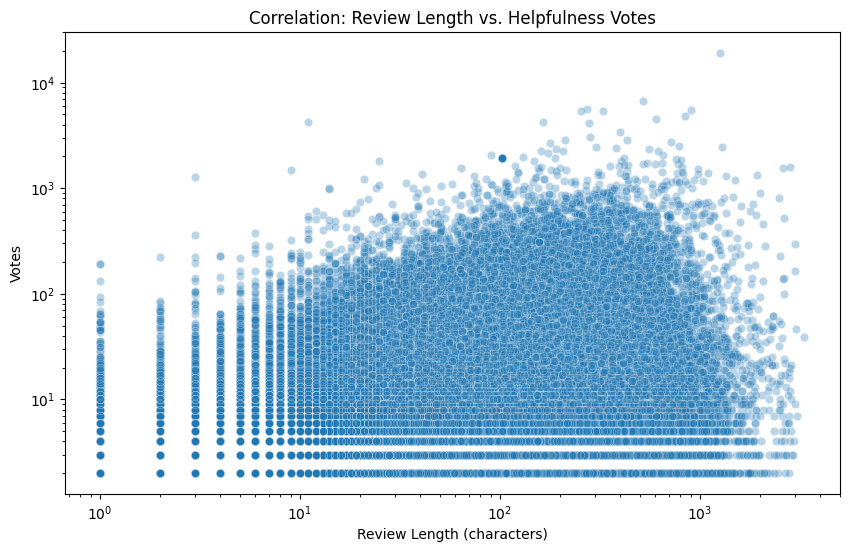

In [11]:
# Complexity Analysis (for ABSA prep)
def analyze_review_complexity(df):
    sample_df = df.select("wordCount", "voteCleaned", "overall").sample(0.1).toPandas()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sample_df, x="wordCount", y="voteCleaned", alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Correlation: Review Length vs. Helpfulness Votes")
    plt.xlabel("Review Length (characters)")
    plt.ylabel("Votes")
    plt.show()

analyze_review_complexity(df_spark)

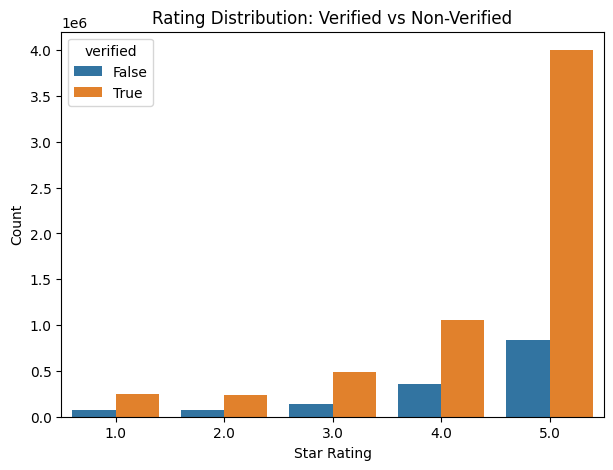

In [12]:
# Rating bias: verified vs non-verified
def analyze_rating_bias_on_verified_status(df):
  sample_df = (
    df.select("verified", "overall")
      .sample(0.1)
      .toPandas()
  )

  plt.figure(figsize=(7,5))
  sns.countplot(data=sample_df, x="overall", hue="verified")
  plt.title("Rating Distribution: Verified vs Non-Verified")
  plt.xlabel("Star Rating")
  plt.ylabel("Count")
  plt.show()

analyze_rating_bias_on_verified_status(df_spark)

/tmp/ipykernel_412688/3621312376.py:8: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="overall", y="count", data=rating_dist, palette="viridis")


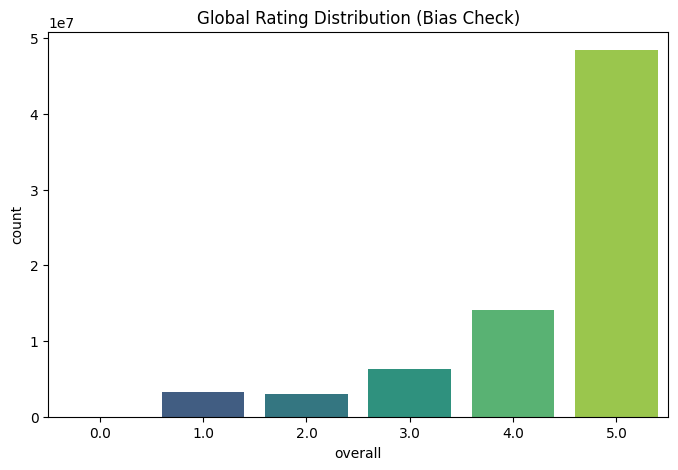

In [13]:
def analyze_rating_bias(df):
    """
    Checks for the 'J-Shaped' distribution common in Amazon reviews.
    """
    rating_dist = df.groupBy("overall").count().orderBy("overall").toPandas()

    plt.figure(figsize=(8, 5))
    sns.barplot(x="overall", y="count", data=rating_dist, palette="viridis")
    plt.title("Global Rating Distribution (Bias Check)")
    plt.show()

analyze_rating_bias(df_spark)

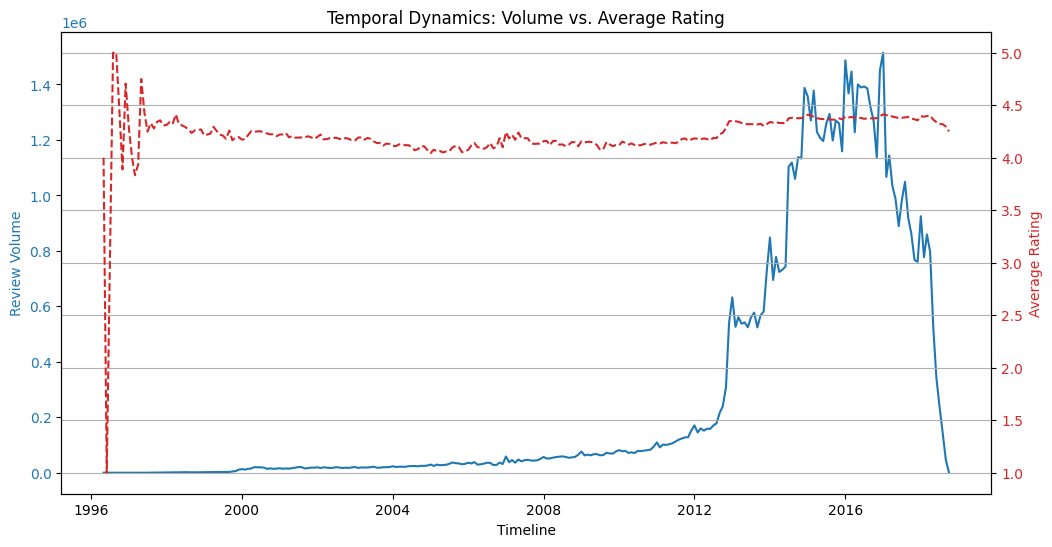

In [ ]:
def perform_temporal_analysis(df):
    """Analyzes how review volume and average ratings evolve over time."""
    temporal_df = df.withColumn("yearMonth", F.date_format("reviewDate", "yyyy-MM")) \
                    .groupBy("yearMonth") \
                    .agg(F.count("asin").alias("reviewCount"),
                         F.avg("overall").alias("avgRating")) \
                    .orderBy("yearMonth") \
                    .toPandas()

    temporal_df['yearMonth'] = pd.to_datetime(temporal_df['yearMonth'])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Timeline')
    ax1.set_ylabel('Review Volume', color='tab:blue')
    ax1.plot(temporal_df['yearMonth'], temporal_df['reviewCount'], color='tab:blue', label='Volume')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Rating', color='tab:red')
    ax2.plot(temporal_df['yearMonth'], temporal_df['avgRating'], color='tab:red', linestyle='--', label='Avg Rating')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Temporal Dynamics: Volume vs. Average Rating')
    plt.grid(True)
    plt.show()

perform_temporal_analysis(df_spark)

/tmp/ipykernel_412688/2108624767.py:15: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=word_counts, palette='viridis')


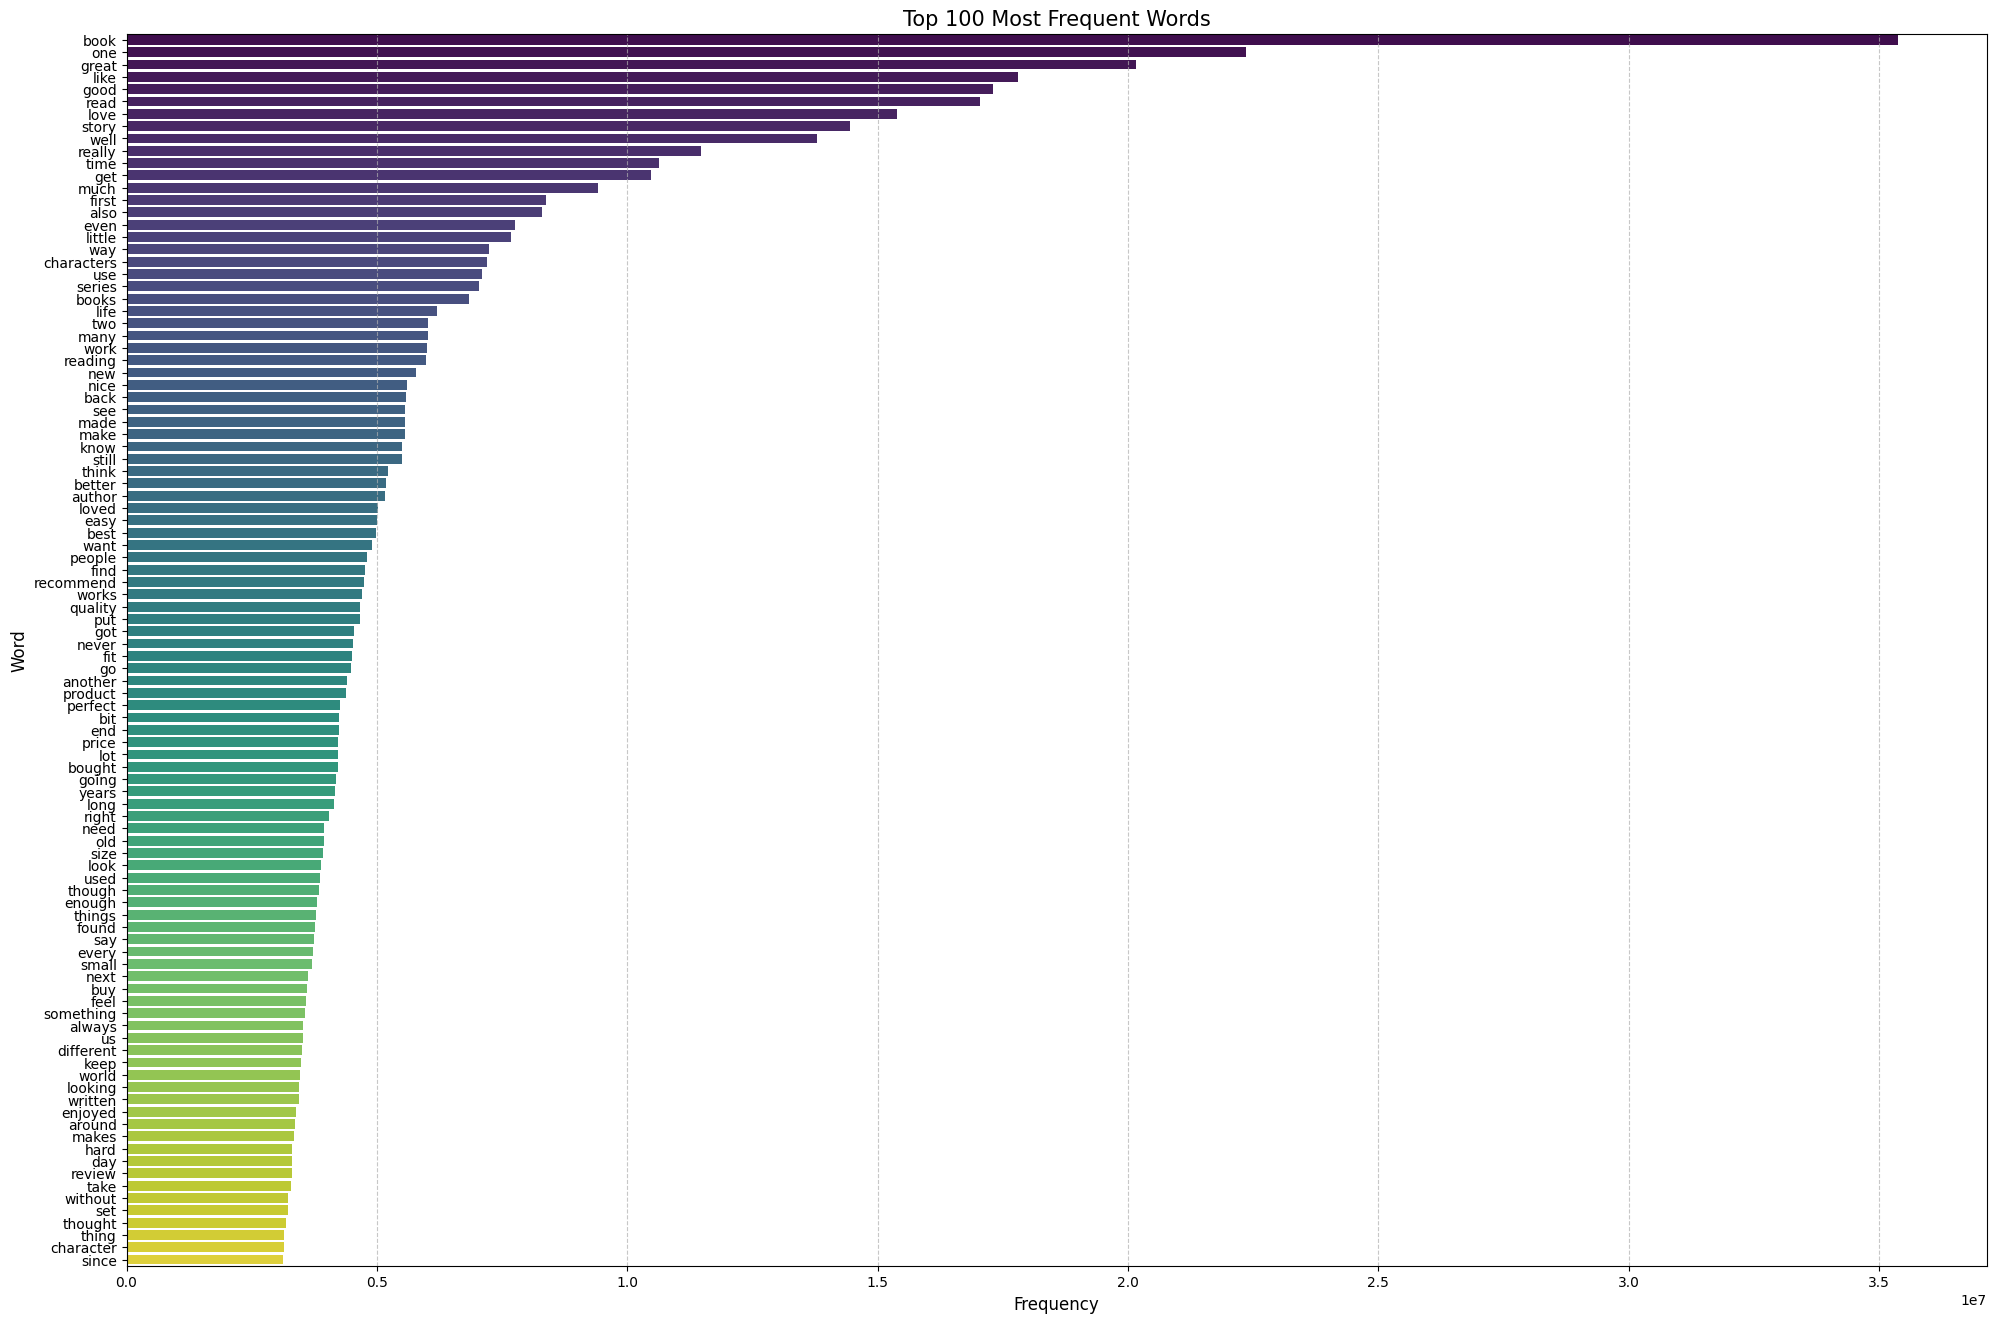

In [ ]:
def plot_word_frequency(df, word_col='review_tokens_nostop', n=20):
    """
    Counts word frequencies, and plots the top N words.
    """
    word_counts = df.select(F.explode(F.col(word_col)).alias("word")) \
                    .groupBy("word") \
                    .count() \
                    .orderBy(F.col("count").desc()) \
                    .limit(n) \
                    .toPandas()

    plt.figure(figsize=(24, 16))
    sns.barplot(x='count', y='word', data=word_counts, palette='viridis')

    plt.title(f'Top {n} Most Frequent Words', fontsize=15)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_word_frequency(df_spark, n=100)

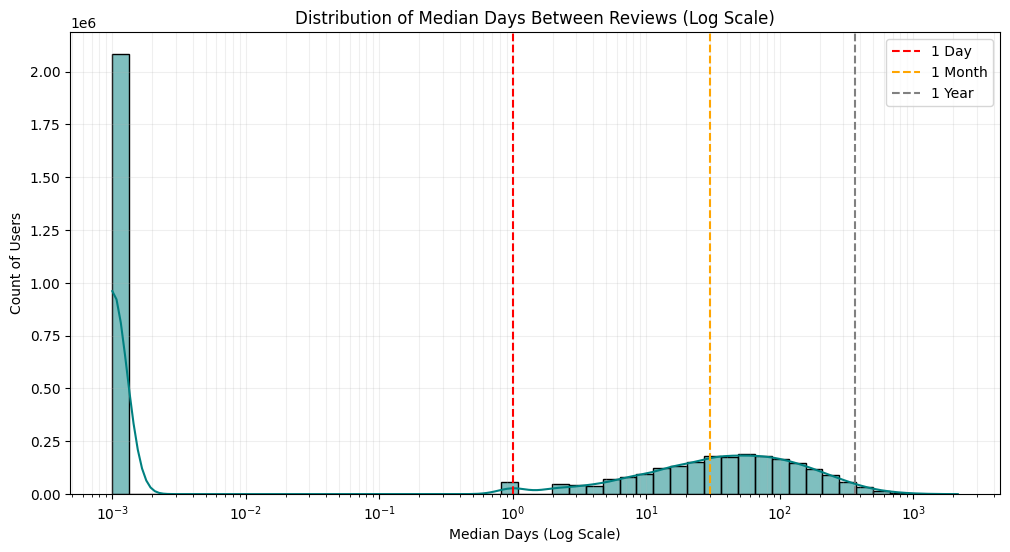

Median of Medians: 2.0000 days
Mean of Medians: 41.2499 days


In [ ]:
def analyze_sequence_quality_refined(df):
    """
    Revised EDA with robust metrics and log-scale plotting.
    """
    window_spec = Window.partitionBy("reviewerID").orderBy("unixReviewTime")

    df_temp = df.withColumn("prevTime", F.lag("unixReviewTime").over(window_spec))
    df_temp = df_temp.withColumn("daysDiff", (F.col("unixReviewTime") - F.col("prevTime")) / 86400)

    user_metrics = df_temp.groupBy("reviewerID").agg(
        F.expr("percentile_approx(daysDiff, 0.5)").alias("medianDayGap"),
        F.avg("daysDiff").alias("meanDayGap")
    ).toPandas()

    plot_data = user_metrics.dropna(subset=['medianDayGap'])

    plt.figure(figsize=(12, 6))
    
    sns.histplot(plot_data['medianDayGap'] + 0.001, bins=50, kde=True, color='teal', log_scale=True)
    
    plt.title("Distribution of Median Days Between Reviews (Log Scale)")
    plt.xlabel("Median Days (Log Scale)")
    plt.ylabel("Count of Users")
    
    plt.axvline(1, color='r', linestyle='--', label='1 Day')
    plt.axvline(30, color='orange', linestyle='--', label='1 Month')
    plt.axvline(365, color='gray', linestyle='--', label='1 Year')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

    print(f"Median of Medians: {plot_data['medianDayGap'].median():.4f} days")
    print(f"Mean of Medians: {plot_data['medianDayGap'].mean():.4f} days")

analyze_sequence_quality_refined(df_spark)

/tmp/ipykernel_412688/1502837804.py:17: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_counts, palette='magma')


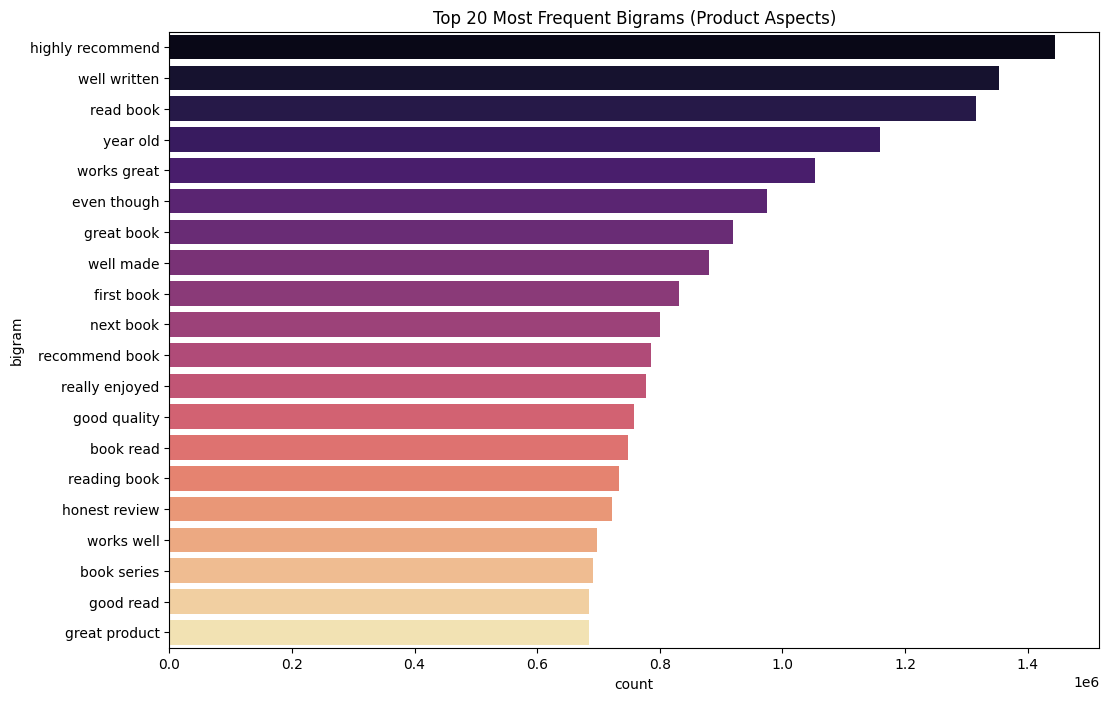

In [17]:
def analyze_top_bigrams(df, n=20):
    """
    Identifies common two-word phrases (Bigrams).
    """
    ngram = NGram(n=2, inputCol="review_tokens_nostop", outputCol="bigrams")
    ngram_df = ngram.transform(df)

    # Explode and count
    bigram_counts = ngram_df.select(F.explode(F.col("bigrams")).alias("bigram")) \
                            .groupBy("bigram") \
                            .count() \
                            .orderBy(F.desc("count")) \
                            .limit(n) \
                            .toPandas()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='bigram', data=bigram_counts, palette='magma')
    plt.title(f"Top {n} Most Frequent Bigrams (Product Aspects)")
    plt.show()

# Run it
analyze_top_bigrams(df_spark)

--- Word Count Statistics ---
Median (p50): 15.0
90th Percentile: 80.0
95th Percentile: 133.0
99th Percentile: 4124.0


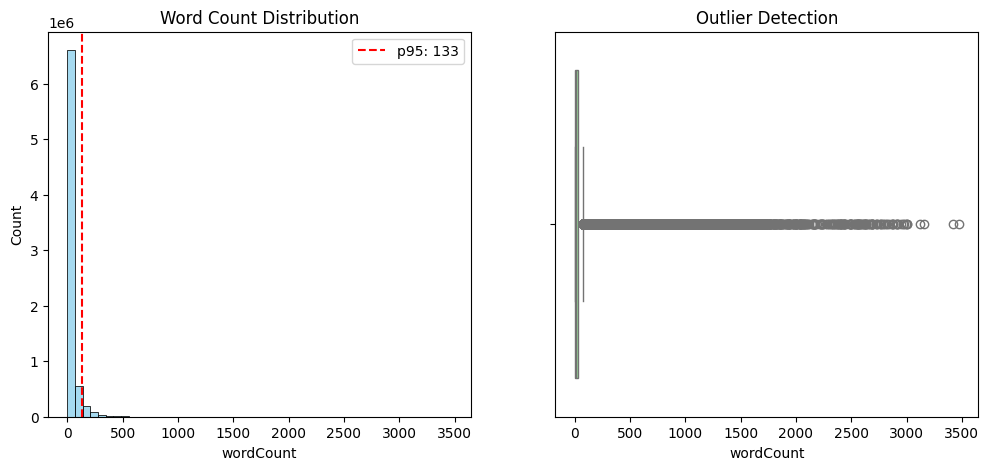

Recommended truncation length (p95): 133 words.


In [4]:
def analyze_token_distribution_safe(df):
    """
    Safely determines word count distribution without crashing the driver.
    """
    # Calculate Statistics in Spark
    quantiles = df.stat.approxQuantile("wordCount", [0.5, 0.9, 0.95, 0.99], 0.01)
    
    print("--- Word Count Statistics ---")
    print(f"Median (p50): {quantiles[0]}")
    print(f"90th Percentile: {quantiles[1]}")
    print(f"95th Percentile: {quantiles[2]}")
    print(f"99th Percentile: {quantiles[3]}")

    pdf_sample = df.select("wordCount").sample(fraction=0.1).toPandas()
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(pdf_sample['wordCount'], bins=50, color='skyblue')
    plt.title("Word Count Distribution")
    plt.axvline(quantiles[2], color='r', linestyle='--', label=f'p95: {int(quantiles[2])}')
    plt.legend()

    # Boxplot for outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=pdf_sample['wordCount'], color='lightgreen')
    plt.title("Outlier Detection")
    
    plt.show()

    print(f"Recommended truncation length (p95): {int(quantiles[2])} words.")

analyze_token_distribution_safe(df_spark)

In [ ]:
def check_sentiment_consistency_improved(df):
    print("--- Checking Sentiment Consistency (Improved Regex) ---")
    
    neg_keywords = ["bad", "terrible", "worst", "disappointed", "broken", "returning", 
                    "horrible", "awful", "waste", "useless", "garbage", "poor"]
    
    pos_keywords = ["great", "excellent", "love", "perfect", "best", "amazing", 
                    "wonderful", "favorite", "awesome"]

    neg_pattern = "(?i)\\b(" + "|".join(neg_keywords) + ")\\b"
    pos_pattern = "(?i)\\b(" + "|".join(pos_keywords) + ")\\b"

    # Logic: 
    # Case A: 5-Star Rating BUT contains negative words AND DOES NOT contain "not [neg_word]"
    
    mismatch_pos_rating = df.filter(
        (F.col("overall") == 5.0) & 
        (F.col("reviewText").rlike(neg_pattern)) & 
        (~F.col("reviewText").rlike("(?i)not " + neg_pattern)) 
    )

    # Case B: 1-Star Rating BUT contains positive words
    mismatch_neg_rating = df.filter(
        (F.col("overall") == 1.0) & 
        (F.col("reviewText").rlike(pos_pattern)) &
        (~F.col("reviewText").rlike("(?i)not " + pos_pattern))
    )

    count_pos = mismatch_pos_rating.count()
    count_neg = mismatch_neg_rating.count()

    print(f"1. Rated 5 Stars but sound Negative: {count_pos}")
    if count_pos > 0:
        mismatch_pos_rating.select("overall", "reviewText").show(3, truncate=100)

    print(f"2. Rated 1 Star but sound Positive:  {count_neg}")
    if count_neg > 0:
        mismatch_neg_rating.select("overall", "reviewText").show(3, truncate=100)

check_sentiment_consistency_improved(df_spark)

--- Checking Sentiment Consistency (Improved Regex) ---


1. Rated 5 Stars but sound Negative: 1948738


+-------+----------------------------------------------------------------------------------------------------+
|overall|                                                                                          reviewText|
+-------+----------------------------------------------------------------------------------------------------+
|    5.0|in the end it is hard to tell the good guys from the bad brilliant tv and now we have to find som...|
|    5.0|slightly cracked is a departure for susan whitfield who has previously written a series of myster...|
|    5.0|                              already broken in mostly easy for my kids to use a great starter glove|
+-------+----------------------------------------------------------------------------------------------------+
only showing top 3 rows

2. Rated 1 Star but sound Positive:  474150
+-------+----------------------------------------------------------------------------------------------------+
|overall|                                  

In [ ]:
def check_sentiment_consistency(df):
    """
    Identifies 'Noisy' labels.
    For example, 5-star ratings with summaries containing 'bad' or 'disappointed'.
    """
    neg_keywords = ["bad", "terrible", "worst", "disappointed", "broken", "returning"]

    mismatch = df.filter((F.col("overall") == 5.0) &
                         (F.col("summary").rlike("(?i)" + "|".join(neg_keywords))))

    mismatch_count = mismatch.count()
    print(f"Detected {mismatch_count} potential 'Positive Rating / Negative Text' mismatches.")

    if mismatch_count > 0:
        print("Sample of mismatched reviews:")
        mismatch.select("overall", "summary").show(5, truncate=False)

check_sentiment_consistency(df_spark)

Detected 136093 potential 'Positive Rating / Negative Text' mismatches.
Sample of mismatched reviews:
+-------+-----------------------------------------------------------------------------------------------------+
|overall|summary                                                                                              |
+-------+-----------------------------------------------------------------------------------------------------+
|5.0    |Not bad (For a Kwiksket)                                                                             |
|5.0    |Great product --- just buy them you won't be disappointed                                            |
|5.0    |He has plenty of room to lounge so we don't feel so bad having to put him in there when we aren't ...|
|5.0    |HER GROOM WAS BADLY SCARED FROM BURNS BUT SHE DID NOT ACT ON IT SHE MARRIED HIM                      |
|5.0    |baduizm x mama's gun: reMASTERED                                                                     |
+-

26/01/15 19:53:00 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-610d2f00-c7a9-474f-a6ab-ca28283eef49. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-610d2f00-c7a9-474f-a6ab-ca28283eef49
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:173)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimize